# Application d'analyse des données de Formule 1 saison 2022
celle que je peux récupérer en tout cas

Cette application est réutilisable pour les prochaines saisons

## Imports

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
import plotly.express as px
import chart_studio.plotly as py
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import json

## Backend
dans cette partie, je fais tous ce qui ne relève pas de l'affichage des graphs.
Cela permet d'avoir directement toutes les données d'un coup pour ensuite juste avoir a
choisir le graph a afficher

In [14]:
# import data
data_speed = pd.read_csv('data/race_avg_speed.csv', sep=",")
data_points = pd.read_csv('data/race_points.csv', sep=",")
data_times = pd.read_csv('data/race_time.csv', sep=",")
data_best_lap = pd.read_csv('data/race_best_lap.csv', sep=",")
data_grid = pd.read_csv("data/race_grid.csv", sep=",")
data_result = pd.read_csv("data/race_result.csv")

data_points_cumsum = data_points.cumsum()
jsonfile = open("teams.json")
teams_pilot = json.load(jsonfile)
pdata = pd.concat([data_result, data_points, data_grid, data_speed, data_times, data_best_lap])
data_team_points = {}
# pour chaque équipe on fait la somme des points de chaque pilote de l'équipe
for team in teams_pilot:
    data_team_points[team] = []
    for rnd in range(data_grid.shape[0]):
        data_team_points[team].append(0)
        for pl in teams_pilot[team]:
            data_team_points[team][rnd] += data_points[pl][rnd]
data_team_points = pd.DataFrame(data_team_points).fillna(0)
data_team_cumsum = data_team_points.cumsum()

# init constants
X = [i for i in range(1, data_points.shape[0]+1)]
n = 6
order = ["ham","rus","ver","per","lec","sai","gas","tsu","ric","nor","oco","alo","vet","str","lat","alb","bot","zho","mag","sch"]
colors = {
    "ham": "#00AA88",
    "rus": "#3C9E8C",
    "ver": "#0000FF",
    "per": "#00006E",
    "lec": "#FF0000",
    "sai": "#5E0101",
    "gas": "#555555",
    "tsu": "#999999",
    "ric": "#FF8C00",
    "nor": "#BA7827",
    "oco": "#FF8AFF",
    "alo": "#C75BC7",
    "vet": "#27542B",
    "str": "#1D9929",
    "lat": "#697DFF",
    "alb": "#293587",
    "bot": "#FF00A2",
    "zho": "#AB006C",
    "mag": "#5C0099",
    "sch": "#9900FF"
}
teams = {
    "redbull": "#FF00FF",
    "mrecedes": "#00FFFF",
    "ferrari": "#FF0000",
    "mclaren": "#FFAA00",
    "alpine": "#FFC0CB",
    "alphatauri": "#AAAAAA",
    "astonmartin": "#00FF00",
    "williams": "#0000FF",
    "alfaromeo": "#000000",
    "haas": "#FFFF00"
}

# prepare heatmap grid/result
grid_result = np.zeros((20, 20))
for pilot in order[:-2]:
    for i in range(data_grid.shape[0]):
        grid_result[data_grid[pilot][i]-1, data_result[pilot][i]-1] += 1




## Frontend
Ici les affichages seront séparé pour pouvoir choisir ce qu'on affiche

### Test data import

In [14]:
# print(data_points_cumsum)
# print(data_points)
# print(data_times)
# print(data_best_lap)
# print(data_grid)

# print(pilots_data)
# print(pdata)
# sns.heatmap(pdata.isna())

# print(teams_pilot)
print(data_team_cumsum)

   redbull  mrecedes  ferrari  mclaren  alpine  alphatauri  astonmartin  \
0        0        27       44        0       8           4            0   
1       37        38       78        6      16           8            0   
2       55        65      104       24      22          10            0   

   williams  alfaromeo  haas  
0         8         11   0.0  
1         8         13   0.0  
2         9         17   0.0  


### nuage de point
un graph avec la position sur la grille en x, et le classement en y. cela permet de predire si l'ordre de la grille est conservé

Text(0, 0.5, 'Classement')

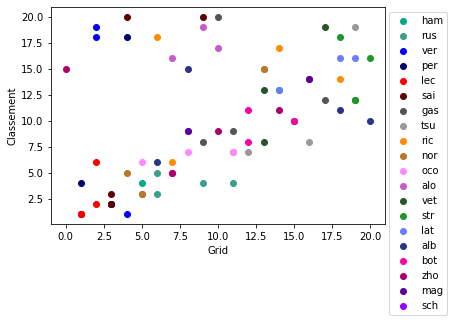

In [4]:
for pilot in order:
    plt.scatter(data_grid[pilot], data_result[pilot], label=pilot, color=colors[pilot])
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.xlabel("Grid")
plt.ylabel("Classement")

toujours un nuage de point, mais avec les temps totaux en x et temps du meilleur tour en y

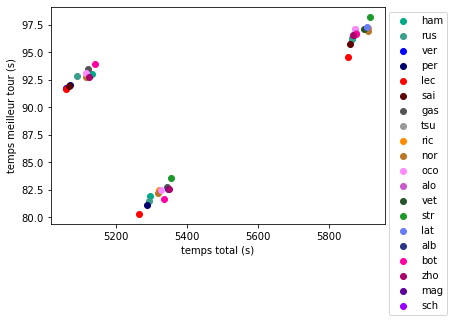

In [7]:
for pilot in order:
    plt.scatter(data_times[pilot], data_best_lap[pilot], color=colors[pilot], label=pilot)
plt.xlabel("temps total (s)")
plt.ylabel("temps meilleur tour (s)")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

### Heatmap

Ici je vais faire toutes les heatmap.

la première ci-dessous est grid/result

<AxesSubplot:>

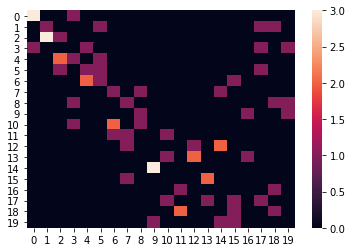

In [8]:
sns.heatmap(grid_result)

### Evolutions

Ici c'est les courbes d'evolutions au cours de la saison

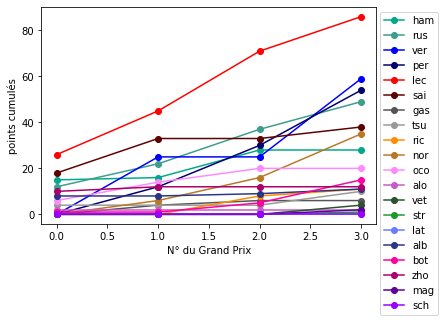

In [15]:
for pilot in order:
    plt.plot(data_points_cumsum[pilot], color=colors[pilot], label=pilot, marker="o")
plt.xlabel("N° du Grand Prix")
plt.ylabel("points cumulés")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

Et même chose mais pour les écuries

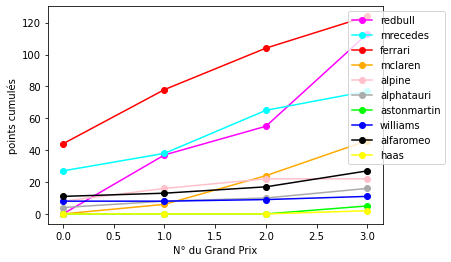

In [16]:
for team in teams:
    plt.plot(data_team_cumsum[team], color=teams[team], label=team, marker="o")
plt.xlabel("N° du Grand Prix")
plt.ylabel("points cumulés")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))